<a href="https://githubtocolab.com/Eunseob/purdue_me597/blob/main/lab/lab10/PL10_Colab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prelab 10.2 Machine Learning 3 - Real-time Sound Recognition for Classification

# CNN model training and evaluation

<br>



Because recent [Colab update on March 8, 2023](https://medium.com/google-colab/colab-updated-to-python-3-9-2593f8b1eb79), the default Python version in Colab is 3.9. This results in [TensorFlow version compatibility](https://www.tensorflow.org/install/source#tested_build_configurations) issues between Colab and Raspberry Pi since Raspberry Pi (Raspberry Pi OS version 10, Buster) uses Python 3.7 as default. Therefore, before we get started, let's first set up Python 3.7 and then install other required and compatible packages on Colab. This takes around 2 minutes.

Note that after you install TensorFlow 2.2.0 in 10th code block, you will see '**RESTART RUNTIME**' button as captured below. Please click the button and move to the next cell so that installed package is able to be applied to Colab session.

**In addition, please make sure that you perform the same procedure in the new Colab file if you want to develop your own machine-learning models and train them for implementation on Raspberry Pi.**

<br>

<img src="https://github.com/Eunseob/purdue_me597/blob/main/lab/img/prelab10_img0.png?raw=true" width="60%">

<br>

In [ ]:
# keep the packages update
!sudo apt-get update -y
!sudo apt upgrade -y

In [ ]:
# install Python3.7 on virtual session
!sudo apt-get install python3.7 python3.7-dev python3.7-distutils libpython3.7-dev

In [ ]:
#change alternatives
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 2

In [ ]:
#Check that it points at the right location
# The version musb be Python 3.7.X
!python3 --version

In [ ]:
# install pip
!curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py
!python3 get-pip.py --force-reinstall

In [ ]:
#install colab's dependencies
!python3 -m pip install ipython ipython_genutils ipykernel jupyter_console prompt_toolkit httplib2 astor

In [ ]:
!sudo apt install python3.7-distutils

In [ ]:
# link to the old google package
!ln -s /usr/local/lib/python3.9/dist-packages/google \
       /usr/local/lib/python3.7/dist-packages/google


In [ ]:
# IPython no longer exposes traitlets like this, it's a separate package now
!sed -i "s/from IPython.utils import traitlets as _traitlets/import traitlets as _traitlets/" /usr/local/lib/python3.7/dist-packages/google/colab/*.py
!sed -i "s/from IPython.utils import traitlets/import traitlets/" /usr/local/lib/python3.7/dist-packages/google/colab/*.py

In [ ]:
# install tensorflow version 2.2.0
# After running this, you have to reconnect the session by clicking 'RESTART RUNTIME' button at the end of the output cell 
!pip install tensorflow==2.2.0
!pip install protobuf==3.20.1

In [ ]:
# Let's check the installed tensorflow version
# The output cell must be 'TensorFlow Version is 2.2.0'
import tensorflow as tf

print('TensorFlow Version is', tf.__version__)

In [ ]:
# Install required Python packages for this colab
!pip install librosa==0.8.1
!pip install matplotlib
!pip install seaborn

## 2.1 Data loading and signal processing

Before we load data and analyze them, let's figure out the experiments for the training data collection. As discussed in the previous session ([Prelab 10.1](https://githubtocolab.com/Eunseob/purdue_me597/blob/main/lab/lab10/PL10_Colab1.ipynb)), we defined the machine's three states: (1) OFF, (2), ON in vacuuming, and (3) ON in air-leaking. The data collection was basically performed in the lab space in a quiet environment. Data was collected from the MTConnect sound stream in WAV format. The audio specifications, such as sampling rate, resolution, and so on, were the same as the MTConnect stream. The configuration of data collection is illustrated in Figure 7. To make a noisy environment, a loudspeaker was placed near the pump.

<img src="https://github.com/Eunseob/purdue_me597/blob/main/lab/img/prelab10_fig7.png?raw=true" width="50%">

*Figure 7 System configuration for sound data collection*


Sound signals from the internal sound sensor for each state of the machine were collected for 1 minute. On top of that, simulating other environmental conditions, the same amount of data was collected in a loud environment in which a loudspeaker generated white noise. Therefore, we have three states data and total 6 sound data in [Github repo](https://github.com/Eunseob/purdue_me597/tree/main/lab/lab10/prelab_data). You will figure out the condition in the filename. Note that each data is 1 minute-long. Description for the filename and states is below.



*   **OFF.wav**
  * Machine is turned off, state 1 (OFF)
*   **OFF_with_noise.wav**
  * Machine is turned off, state 1 (OFF)
*   **ON_vacuum.wav**
  * Machine is on in vacuuming, state 2 (ON/Vacuuming)
*   **ON_vacuum_with_noise.wav**
  * Machine is on in vacuuming and noisy environment, state 2 (ON/Vacuuming)
*   **ON_air_leaking.wav**
  * Machine is on in air-leaking, state 3 (ON/Air-leaking)
*   **ON_air_leaking_with_noise.wav**
  * Machine is on in air-leaking and noisy environment, state 3 (ON/Air-leaking)


Let's listen to the sound of each case and then load data to analyze it.

### Loading data

We will use bash command in the code block below to load data in Colab session. Note that you can use Colab interface to upload data or mount your Google Drive instead.

In [ ]:
# loading sound data in this Colab session by bash
# It takes a few seconds.
!wget -O OFF.wav https://github.com/Eunseob/purdue_me597/blob/main/lab/lab10/prelab_data/OFF.wav?raw=true
!wget -O OFF_with_noise.wav https://github.com/Eunseob/purdue_me597/blob/main/lab/lab10/prelab_data/OFF_with_noise.wav?raw=true
!wget -O ON_vacuum.wav https://github.com/Eunseob/purdue_me597/blob/main/lab/lab10/prelab_data/ON_vacuum.wav?raw=true
!wget -O ON_vacuum_with_noise.wav https://github.com/Eunseob/purdue_me597/blob/main/lab/lab10/prelab_data/ON_vacuum_with_noise.wav?raw=true
!wget -O ON_air_leaking.wav https://github.com/Eunseob/purdue_me597/blob/main/lab/lab10/prelab_data/ON_air_leaking.wav?raw=true
!wget -O ON_air_leaking_with_noise.wav https://github.com/Eunseob/purdue_me597/blob/main/lab/lab10/prelab_data/ON_air_leaking_with_noise.wav?raw=true

After running the cell above, Files of your Colab session look like the capture below.

<img src="https://github.com/Eunseob/purdue_me597/blob/main/lab/img/prelab10_img1.png?raw=true" width="30%">

Let's play each data in the following code blocks and perform Task 2.1.

In [ ]:
from IPython.display import Audio, display

# Filenames for each data
OFF = 'OFF.wav' # OFF state filename
OFF_with_noise = 'OFF_with_noise.wav' # OFF in noisy environment
ON_vacuum = 'ON_vacuum.wav' # ON in vacuuming
ON_vacuum_with_noise = 'ON_vacuum_with_noise.wav' # ON in vacuuming and noisy environment
ON_air_leaking = 'ON_air_leaking.wav' # ON in air-leaking
ON_air_leaking_with_noise = 'ON_air_leaking_with_noise.wav' # On in air-leaking and noisy environment

In [ ]:
print(OFF)
display(Audio(OFF))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(OFF_with_noise)
display(Audio(OFF_with_noise))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(ON_vacuum)
display(Audio(ON_vacuum))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(ON_vacuum_with_noise)
display(Audio(ON_vacuum_with_noise))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(ON_air_leaking)
display(Audio(ON_air_leaking))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(ON_air_leaking_with_noise)
display(Audio(ON_air_leaking_with_noise))

Output hidden; open in https://colab.research.google.com to view.

### Task 2.1

After listening to the sound according to each state (condition), do you think you can figure out the state based only on sound? Describe how you hear the sounds depending on the states.



---

Write down your answer here.

---



### Signal processing

You definitely tell the differences between OFF and ON states. In addition, you probably "feel" different sounds between ON/vacuuming and ON/air-leaking states. Using signal processing, let's analyze data to see how signals are different. To analyze audio, we will mainly use Python [librosa](https://librosa.org/doc/latest/index.html#) package. The librosa is a Python package for music and audio analysis.

Figure 8 illustrates the procedure of development of a machine learning model in a typical and simple. As we did in Lab 8 and Lab 9, there are many ways to perform signal processing. Even we can use raw data for a feature for the training model input. This process, making input data for a machine learning model, is normally called feature extraction or feature engineering. When determining the feature, we have to consider many aspects, such as data flow, dimension, coherence, efficiency, effectiveness, representativeness, performance, and so on. As a practice in this lab, we will only use one feature, however, it is highly recommended to try other features for training the model. In addition, upon the evaluation, we are able to optimize not only feature extraction method but also machine learning model (hyper parameters, architecture, and so on) for the best performance.

<img src="https://github.com/Eunseob/purdue_me597/blob/main/lab/img/prelab10_fig8.png?raw=true" width="80%">

*Figure 8 Development procedure of a typical and simple machine learning model*

As a feature for the model, we will use Mel-spectrogram. The Mel-scale is a human perceived frequency of a pure tone to its actual measured frequency. Humans are much better to tell subtle changes at low frequencies than at high frequencies. Mel-spectrogram is more suitable for human auditory sensing that indicates the linear distirubtion under 1,000 Hz and the logarithm growth above 1,000 Hz, which result in many ASR (automatic speech recognition) techniques adopt the Mel-scale as a step of feature extractions.

In the following code blocks, let's visualize data and practice Mel-spectrogram process. Of course, you can create your own method for the signal processing using Python basic functions, NumPy, SciPy, and so on. However, we will take advantage of the librosa package. Visit [librosa.feature.melspectrogram](https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html) and [Understanding the Mel Spectrogram](https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53) to figure out the method and Mel-spectrogram.


In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

N_FFT = 2048 # Number of FFT points, because MTConnect stream chunk size is 2048. This is a constant.
y_off, sr = librosa.load(OFF, sr=48000) # y_off is audio data in off state and sr is sampling rate
M_off = librosa.feature.melspectrogram(y=y_off, sr=sr, n_fft=N_FFT, hop_length=int(N_FFT/4), win_length=N_FFT, window='hann', n_mels=128) # This is Mel-spectrogram

Text(0.5, 0.98, 'OFF.wav')

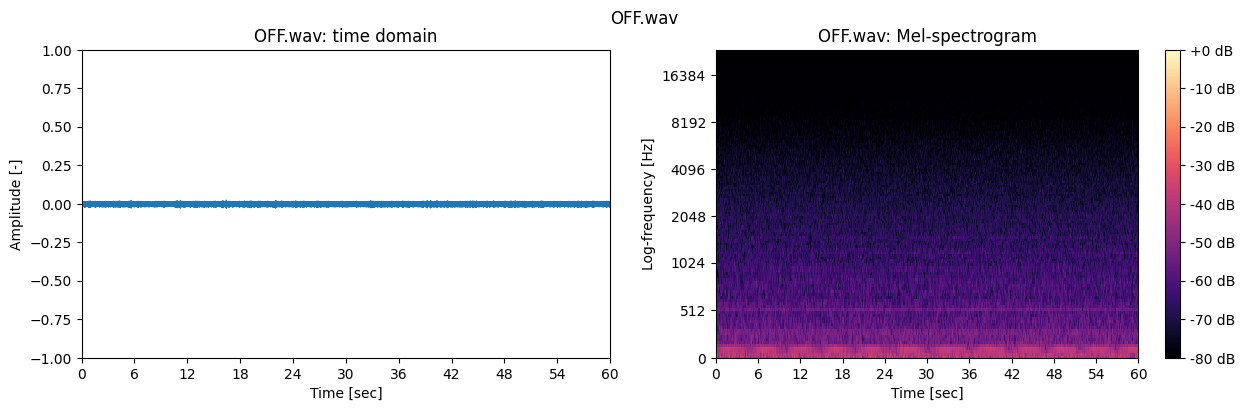

In [ ]:
# This example plots time-domain (raw signal) on the left-hand side and spectrogram on the right-hand side
# Note that legend (color) means relative signal intensity in dB unit in the spectrogram.
# Also, in the spectrogram, the y-axis (frequency) is log scale.
fig, ax = plt.subplots(1,2, sharex=True, figsize=(15,4))
librosa.display.waveplot(y_off, sr=sr, ax=ax[0]) # time domain (raw data) plot
img = librosa.display.specshow(librosa.power_to_db(2*abs(M_off)/N_FFT, ref=1), ax=ax[1], x_axis='time', y_axis='mel', sr=sr, vmin=-80, vmax=0) # mel-spectrogram plot
ax[0].set(title=OFF+": time domain", ylim=[-1, 1], xlim=[0, 60], ylabel="Amplitude [-]", xlabel="Time [sec]")
ax[1].set(title=OFF+": Mel-spectrogram", ylabel="Log-frequency [Hz]", xlabel="Time [sec]")
cbar = fig.colorbar(img, ax=ax[1], format="%+2.0f dB")
fig.suptitle(OFF)

Text(0.5, 0.98, 'ON_vacuum.wav')

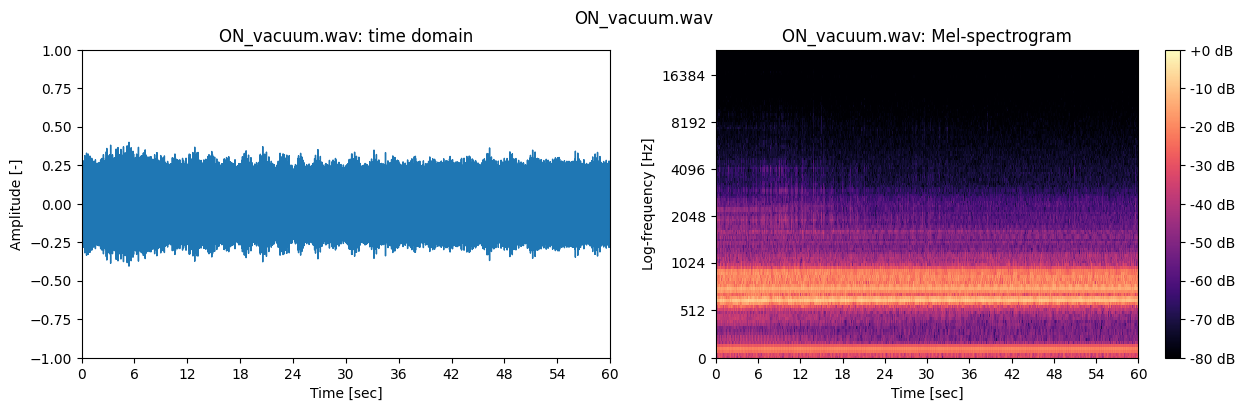

In [ ]:
# This example is for plotting ON/leaking

y_vacuum, sr = librosa.load(ON_vacuum, sr=48000) # y_vacuum is audio data in on/vacuuming state and sr is sampling rate
M_vacuum = librosa.feature.melspectrogram(y_vacuum, sr=sr, n_fft=N_FFT, hop_length=int(N_FFT/4), win_length=N_FFT, window='hann', n_mels=128)

fig, ax = plt.subplots(1,2, sharex=True, figsize=(15,4))
librosa.display.waveplot(y_vacuum, sr=sr, ax=ax[0]) # time domain (raw data) plot
img = librosa.display.specshow(librosa.power_to_db(2*abs(M_vacuum)/N_FFT, ref=1), ax=ax[1], x_axis='time', y_axis='mel', sr=sr, vmin=-80, vmax=0) # mel-spectrogram plot
ax[0].set(title=ON_vacuum+": time domain", ylim=[-1, 1], xlim=[0, 60], ylabel="Amplitude [-]", xlabel="Time [sec]")
ax[1].set(title=ON_vacuum+": Mel-spectrogram", ylabel="Log-frequency [Hz]", xlabel="Time [sec]")
cbar = fig.colorbar(img, ax=ax[1], format="%+2.0f dB")
fig.suptitle(ON_vacuum)

Text(0.5, 0.98, 'ON_air_leaking.wav')

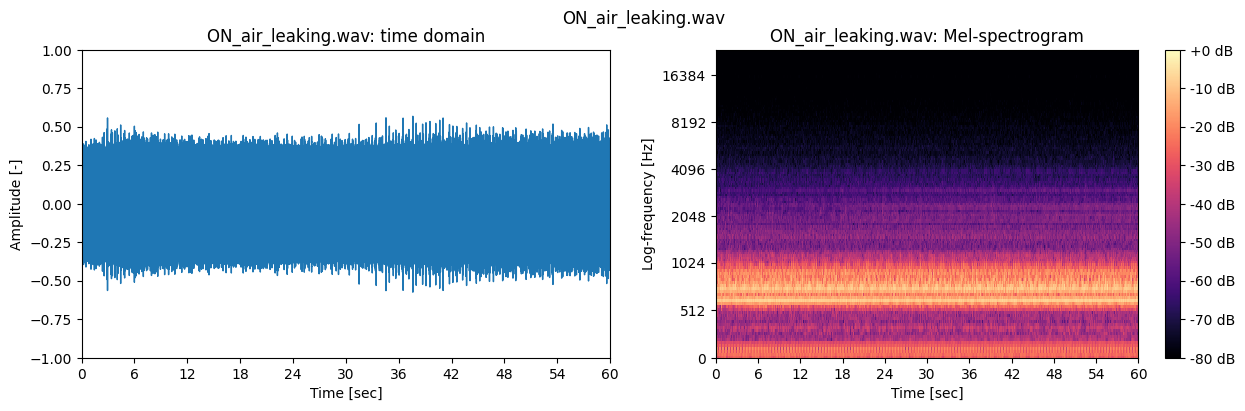

In [ ]:
# This example is for plotting ON/vacuuming

y_airleaking, sr = librosa.load(ON_air_leaking, sr=48000) # y_vacuum is audio data in on/vacuuming state and sr is sampling rate
M_airleaking = librosa.feature.melspectrogram(y_airleaking, sr=sr, n_fft=N_FFT, hop_length=int(N_FFT/4), win_length=N_FFT, window='hann', n_mels=128)

fig, ax = plt.subplots(1,2, sharex=True, figsize=(15,4))
librosa.display.waveplot(y_airleaking, sr=sr, ax=ax[0]) # time domain (raw data) plot
img = librosa.display.specshow(librosa.power_to_db(2*abs(M_airleaking)/N_FFT, ref=1), ax=ax[1], x_axis='time', y_axis='mel', sr=sr, vmin=-80, vmax=0) # mel-spectrogram plot
ax[0].set(title=ON_air_leaking+": time domain", ylim=[-1, 1], xlim=[0, 60], ylabel="Amplitude [-]", xlabel="Time [sec]")
ax[1].set(title=ON_air_leaking+": Mel-spectrogram", ylabel="Log-frequency [Hz]", xlabel="Time [sec]")
cbar = fig.colorbar(img, ax=ax[1], format="%+2.0f dB")
fig.suptitle(ON_air_leaking)

### Task 2.2

Using the code blocks above, plot other data below.


*   OFF_with_noise.wav
*   ON_vacuum_with_noise.wav
*   ON_air_leaking_with_noise_wave.wav


By comparing and analyzing data, discuss differences between the states.




In [ ]:
## variables for the following session and this task

y_off_noise, sr = librosa.load(OFF_with_noise, sr=48000) # y_off is audio data in off state and sr is sampling rate
M_off_noise = librosa.feature.melspectrogram(y_off_noise, sr=sr, n_fft=N_FFT, hop_length=int(N_FFT/4), win_length=N_FFT, window='hann', n_mels=128) # This is Mel-spectrogram

y_vacuum_noise, sr = librosa.load(ON_vacuum_with_noise, sr=48000) # y_vacuum is audio data in on/vacuuming state and sr is sampling rate
M_vacuum_noise = librosa.feature.melspectrogram(y_vacuum_noise, sr=sr, n_fft=N_FFT, hop_length=int(N_FFT/4), win_length=N_FFT, window='hann', n_mels=128)

y_airleaking_noise, sr = librosa.load(ON_air_leaking_with_noise, sr=48000) # y_vacuum is audio data in on/vacuuming state and sr is sampling rate
M_airleaking_noise = librosa.feature.melspectrogram(y_airleaking_noise, sr=sr, n_fft=N_FFT, hop_length=int(N_FFT/4), win_length=N_FFT, window='hann', n_mels=128)

In [ ]:
## Add more code blocks for Task 2.2 if needed





---

Write down your answer to Task 2.2 here.

---



### Labeling and CNN model data input pipeline

Let's make the input data with labeling (output) for the CNN model training. Before discretizing data for the inputs, let's understand how we split data. First we set the size of window (window size), so-called input data length. And then scan the entire dataset with a scanning interval as shown in Figure 9.

<img src="https://github.com/Eunseob/purdue_me597/blob/main/lab/img/prelab10_fig9.gif?raw=true" width="60%">

*Figure 9 Scanning for taking input data*

As an example, let's have the input data 1 second. However, when it comes to the MTConnect straem, the chunk size (minimum data length in a sequence) is 2048 data points, which means the chunk is 0.042667 sec because the sampling rate is 48000 Hz. We calculate how many chunks (*N*<sub>seq</sub>) are close to 1 second. The number of chunks close to 1 second is 23 (actually 0.98133 sec). The number of data points for the window size is 47,104 which can be calculated by multiplying the chunk size and the number of the sequences (N<sub>chunk</sub>×N<sub>seq</sub>). Also, let's have a scanning interval to equal the chunk size. That means in every interval size, 1-second data is taken as input data after performing signal processing. The signal processing (feature extraction) is the same as in the section above, Mel-spectrogram. Input data specifications and feature extraction are summarized below.

*   Window size: 0.981333 sec
  * *N*<sub>chunk</sub> = 2048
  * *N*<sub>seq</sub> = 23
  * *f*<sub>s</sub> (sampling frequency) = 48000 Hz
  * *t*<sub>window</sub> = 0.98133 sec. (*N*<sub>chunk</sub>×*N*<sub>seq</sub>/*f*<sub>s</sub>)
  * Scanning interval = 0.042667 sec (= 2048 data points)

*   Feature: Mel-spectrogram
  * N_FFT (number of FFT points) = 2048
  * hop_length = 512
  * Windowing function = hanning
  * n_mels (number of Mel-filter banks) = 128

It is expected that the input data has a 2D-array and the shape (dimension) is (128×93). With this information, let's perform splitting data by scanning the dataset for generating the machine learning input and labeling.




In [ ]:
# This code prints out length of the audio file (OFF.WAV) in second unit.
print("Total data points of an audio file: ", len(y_off))
print("Total length of an audio file: ",len(y_off)/sr, "sec")

n_chunk = 2048 # Number of data points in a chunk
n_seq = 23 # Number of the required sequences for a window
n_interval = 2048 # Number of data points for interval
n_total_lengh = len(y_off) # Number of total data points
n_window_length = n_chunk * n_seq # number of data points in a window
N_window = int((len(y_off) - n_window_length)/n_interval) + 1 # Number of windows from the data

print("\nTotal number of windows for training data input per file:", N_window)
print("Length of each window:",n_window_length/sr, "sec")

In [ ]:
# Let's conduct feature extraction and visualization for the first data of OFF.wav
y_off_1 = y_off[0:n_chunk*n_seq] # taking the first window by indexing
M_off_1 = librosa.feature.melspectrogram(y_off_1, sr=sr, n_fft=N_FFT, hop_length=int(N_FFT/4), win_length=N_FFT, window='hann', n_mels=128)
S_off_1 = 2*abs(M_off_1)/N_FFT # power of Mel-spectrogram as input

fig, ax = plt.subplots(1,2, sharex=True, figsize=(15,4))
librosa.display.waveplot(y_off_1, sr=sr, ax=ax[0]) # time domain (raw data) plot
img = librosa.display.specshow(librosa.power_to_db(S_off_1, ref=1), ax=ax[1], x_axis='time', y_axis='mel', sr=sr, vmin=-80, vmax=0) # mel-spectrogram plot in dB unit
ax[0].set(title=OFF+": time domain", ylim=[-1, 1], xlim=[0, 1], ylabel="Amplitude [-]", xlabel="Time [sec]")
ax[1].set(title=OFF+": Mel-spectrogram", ylabel="Log-frequency [Hz]", xlabel="Time [sec]")
cbar = fig.colorbar(img, ax=ax[1], format="%+2.0f dB")
fig.suptitle(OFF+": the first input data")

In [ ]:
# Let's conduct feature extraction and visualization for the first data of ON_vacuuming.wav
y_vacuum_1 = y_vacuum[0:n_chunk*n_seq] # taking the first window by indexing
M_vacuum_1 = librosa.feature.melspectrogram(y_vacuum_1, sr=sr, n_fft=N_FFT, hop_length=int(N_FFT/4), win_length=N_FFT, window='hann', n_mels=128)
S_vacuum_1 = 2*abs(M_vacuum_1)/N_FFT # power of Mel-spectrogram as input

fig, ax = plt.subplots(1,2, sharex=True, figsize=(15,4))
librosa.display.waveplot(y_vacuum_1, sr=sr, ax=ax[0]) # time domain (raw data) plot
img = librosa.display.specshow(librosa.power_to_db(S_vacuum_1, ref=1), ax=ax[1], x_axis='time', y_axis='mel', sr=sr, vmin=-80, vmax=0) # mel-spectrogram plot in dB unit
ax[0].set(title=ON_vacuum+": time domain", ylim=[-1, 1], xlim=[0, 1], ylabel="Amplitude [-]", xlabel="Time [sec]")
ax[1].set(title=ON_vacuum+": Mel-spectrogram", ylabel="Log-frequency [Hz]", xlabel="Time [sec]")
cbar = fig.colorbar(img, ax=ax[1], format="%+2.0f dB")
fig.suptitle(ON_vacuum+": the first input data")

In [ ]:
# Let's conduct feature extraction and visualization for the first data of ON_air_leaking.wav
y_airleaking_1 = y_airleaking[0:n_chunk*n_seq] # taking the first window by indexing
M_airleaking_1 = librosa.feature.melspectrogram(y_airleaking_1, sr=sr, n_fft=N_FFT, hop_length=int(N_FFT/4), win_length=N_FFT, window='hann', n_mels=128)
S_airleaking_1 = 2*abs(M_airleaking_1)/N_FFT # power of Mel-spectrogram as input

fig, ax = plt.subplots(1,2, sharex=True, figsize=(15,4))
librosa.display.waveplot(y_airleaking_1, sr=sr, ax=ax[0]) # time domain (raw data) plot
img = librosa.display.specshow(librosa.power_to_db(S_airleaking_1, ref=1), ax=ax[1], x_axis='time', y_axis='mel', sr=sr, vmin=-80, vmax=0) # mel-spectrogram plot in dB unit
ax[0].set(title=ON_air_leaking+": time domain", ylim=[-1, 1], xlim=[0, 1], ylabel="Amplitude [-]", xlabel="Time [sec]")
ax[1].set(title=ON_air_leaking+": Mel-spectrogram", ylabel="Log-frequency [Hz]", xlabel="Time [sec]")
cbar = fig.colorbar(img, ax=ax[1], format="%+2.0f dB")
fig.suptitle(ON_air_leaking+": the first input data")

### Task 2.3

The first input data processing from an audio file is given above, can you take the second, and third input data? (*Hint: use indexing of the raw data (y)*)

 How to generalize/express the process for n<sup>th</sup> data input?



---

Write down your answer here.

---



In [ ]:
### You can use this code block to test Task 2.3 
### Try it!


<br></br>
Now, let's build up the input pipeline for training model. The given function below, *get_input_data*, is to process feature extraction for making the training dataset.

In [ ]:
def get_input_data(y, label, N_window, N_interval, N_seq, N_chunk, n_fft, hop_length, sr):
  ## Args decription below
  # y is a raw data (sound signal) for being processed.
  # label is the state (condition), string dtype
  # N_window is number of windows to be splitted for input data from the raw data.
  # N_interval is the scanning interval.
  # N_seq is number of the seuqneces in MTConnect stream to have a specific length of window.
  # N_chunk is a chunk size in which a sequence of MTConnect has data points.
  # n_fft is number of FFT points.
  # hop_length is hop length when spectrogram calculation
  # sr is sampling rate of the audio.

  X = [] # initialize input data array
  Y = [] # initialize label data array
  for i in range(N_window):
    y_temp = y[i*N_interval:(i*N_interval)+N_chunk*N_seq]
    x_temp = librosa.feature.melspectrogram(y_temp, sr=sr, n_fft=n_fft, 
                                            hop_length=hop_length,
                                            win_length=n_fft, window='hann',
                                            n_mels=128)
    feature_temp = 2*abs(x_temp)/n_fft
    Y.append(label)
    X.append(feature_temp)
  
  return np.array(X), np.array(Y)

In [ ]:
# X_off and Y_off are training input data and labels, respectively.
# It takes tens of seconds. If you create your own function to split data by taking not raw data but spectrogram as an argument, it will be much faster.
X_off, Y_off = get_input_data(y=y_off, label="OFF", N_window=N_window, N_interval=n_interval, N_seq=n_seq, N_chunk=n_chunk, n_fft=N_FFT, hop_length=int(N_FFT/4), sr=sr)

print("X_off shape is",X_off.shape)
print("Y_off shape is",Y_off.shape)

Let's understand the input data after processing (Figure 10). X_off (training input) has (k, n, m) shape, (1384, 128, 93) in this case. Y_off (training label) has (1384,) shape. This means the number of data for training for "OFF" label is 1384. Each input data (window) has 128×93 size of 2D-array, which is the power of the Mel-spectrogram. The column, n=128, represents frequency (Mel) components and the row, m=93, represents time components. Because raw sound data itself in WAV format is normalized from -1 to 1, we don't need to normalize them for training input.

<img src="https://github.com/Eunseob/purdue_me597/blob/main/lab/img/prelab10_fig10.png?raw=true" width="90%">

*Figure 10 Understanding processing and shape of input data for training*

In [ ]:
### keep working on other data, this may take a few minutes

X_off_noise, Y_off_noise = get_input_data(y=y_off_noise, label="OFF", N_window=N_window, N_interval=n_interval, N_seq=n_seq, N_chunk=n_chunk, n_fft=N_FFT, hop_length=int(N_FFT/4), sr=sr)

X_vacuum, Y_vacuum = get_input_data(y=y_vacuum, label="ON/vacuum", N_window=N_window, N_interval=n_interval, N_seq=n_seq, N_chunk=n_chunk, n_fft=N_FFT, hop_length=int(N_FFT/4), sr=sr)
X_vacuum_noise, Y_vacuum_noise = get_input_data(y=y_vacuum_noise, label="ON/vacuum", N_window=N_window, N_interval=n_interval, N_seq=n_seq, N_chunk=n_chunk, n_fft=N_FFT, hop_length=int(N_FFT/4), sr=sr)

X_airleaking, Y_airleaking = get_input_data(y=y_airleaking, label="ON/airleaking", N_window=N_window, N_interval=n_interval, N_seq=n_seq, N_chunk=n_chunk, n_fft=N_FFT, hop_length=int(N_FFT/4), sr=sr)
X_airleaking_noise, Y_airleaking_noise = get_input_data(y=y_airleaking_noise, label="ON/airleaking", N_window=N_window, N_interval=n_interval, N_seq=n_seq, N_chunk=n_chunk, n_fft=N_FFT, hop_length=int(N_FFT/4), sr=sr)


In [ ]:
# concatenate all data in training data
# number of each input dataset is 1348, and we have total 6 data which has same size
# therefore, number of training data will be 8088
X_data = np.concatenate((X_off, X_off_noise, X_vacuum, X_vacuum_noise, X_airleaking, X_airleaking_noise), axis=0)
Y_data = np.concatenate((Y_off, Y_off_noise, Y_vacuum, Y_vacuum_noise, Y_airleaking, Y_airleaking_noise), axis=0)

In [ ]:
import seaborn as sns
# seaborn is a statictical data visualization Python package

# before we plot the label frequency, we can expect how much data is in each label.
# Calculate the frequencies before you run this code.
# Are the results as you expected?

plt.figure()
plt.title("Label frequency for vacuum pump sound training")
ax = sns.countplot(x=Y_data)
for container in ax.containers:
  ax.bar_label(container)
plt.show()

To handling and evaluate training data, we will use [scikit-learn Python package](https://scikit-learn.org/stable/index.html) which is known as sklearn. Practically, [sklearn](https://scikit-learn.org/stable/index.html), [keras](https://keras.io/) with [TensorFlow](https://www.tensorflow.org/) are most widely used tool for ML training and implementation.

Before we split train and test (validation) dataset, let's encode the label data for training format. As defined, our problem (purpose) is a multi-class classification. Each class (normally formatted as positive integer) represents a state (operational condition) in this example.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

enc = LabelEncoder() # encoder object
enc.fit(Y_data)
Y_data_enc = enc.transform(Y_data) # Encoding from string labels to integers; 0: OFF, 1: ON/airleaking, 2: ON/vacuum because encoding sort alphabetic order.
Y_label = to_categorical(Y_data_enc) # categorical labeling of the integer index; [1 0 0]: OFF, [0 1 0]: ON/airleaking, [0 0 1]: ON/vacuum

In [ ]:
# using this code block,
# check the encoding performed as you expected.
# Note that, because order of encoding is sorted by ascending order,
# 0 represents "OFF", 1 represents "ON/airleaking", 2 represents "ON/vacuum"
# The encoded integer index means principle axis of the categorical matrix,
# for the model training, 0, 1, and 2 turn out [1 0 0], [0 1 0], and [0 0 1], respectively.

print("Y_data:", Y_data)
print("Encoded Y_data:", Y_data_enc)
print("Encoded classes:", enc.classes_)
print("Categorical transform:", Y_label)

In [ ]:
# Let's split training and testing dataset.
# X_train and Y_train will be used for training weights, bias, filters and so on.
# X_test and Y_test will be used for validating while training.
# In this example, we have 20% test data size. Therefore, the training data is 80%.

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_label, test_size=0.2, random_state=40)
print("Number of data for training: {}".format(len(X_train)))
print("Number of data for validation: {}".format(len(X_test)))

Now, we are ready to start training CNN model.

## 2.2 CNN model training

For the operational state prediction of the vacuum pump, we will use a convolutional neural network (CNN or ConvNet) architecture. While CNNs are mostly used for image classification/recognition, they also have been widely applied for sound recognition and classification tasks. CNNs are a type of multi-layer neural networks that typically contain convolution layers, subsampling layers, and fully connected (FC) layers. Even if the networks are complex because of a large amount of connectivity, the use of shared wieghts within layers helps in reducing the number of parameters that should be trained. Parameter sharing makes CNNs greatly reduce the number of unique model parameters and significantly increase the size of the network without requiring corresponding increase in training data.

 A CNN can have a few or hundreds of layers that each learn to detect different features of an image. Filters are applied to each training image at different resolutions, and output of each convoluted image is used as the input of the next layer. Visit [Towards Data Science](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53), and [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2021/05/convolutional-neural-networks-cnn/) to grasp more about CNN.

The CNN architecture in this example is shown in Figure 11. Red-colored parameters in the architecture are adjustable hyperparameters. We will use two convolutional layers and two hidden layers. If you are interested, try [common CNN archtectures](https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d), such as AlexNet, VGG, GoogleNet, and so on.  As input, the CNN takes tensors of shape (freq. components, time components) of Mel-spectrogram. The output node will be one among "OFF" (0), "ON/airleaking" (1), and "ON/vacuum" (2). Let's create the CNN architecture using TensorFlow and Keras API.

<img src="https://github.com/Eunseob/purdue_me597/blob/main/lab/img/prelab10_fig11.png?raw=true" width="80%">

*Figure 10 CNN architecture for vacuum pump operational state classification*

### Creating CNN model

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras import layers

model = tf.keras.Sequential() # model obj. takes sequential model
model.add(layers.Reshape((X_train.shape[1], X_train.shape[2], 1), input_shape=(X_train.shape[1], X_train.shape[2]))) # reshaping the input to ingest 2D CNN layer
model.add(layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu')) # first 2D CNN layer
model.add(layers.MaxPooling2D(pool_size=(3,3))) # max pooling layer
model.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')) # second 2D CNN layer
model.add(layers.MaxPooling2D(pool_size=(3,3))) # max pooling layer
model.add(layers.Flatten()) # flatten layer
model.add(layers.Dense(64, activation='relu')) # first hidden layer
model.add(layers.Dense(128, activation='relu')) # second hidden layer
model.add(layers.Dense(units=Y_train.shape[1], activation='softmax', name='output')) # output layer (node)
model.summary() # This will show the model object

### Compiling and training the model

By running the code block below, let's compile the CNN model and then train it!  




In [ ]:
## Other hyperparameters
BATCH = 256 # the number of samples per gradient update
EPOCH = 5 # how many cycles will be trained in an entire dataset passed forward and backward through neural network
LR = 10e-4 # learning rate is to control how much to change the model in response to the estimated error per graident update, normally choosen between 10e-3 and 10e-6

# compiling the CNN model, loss function is categorical crossentropy and training metric is accuracy
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy'])

# This will start model training and take a few minutes
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=BATCH, epochs=EPOCH, verbose=1)


### Evaluate model

Let's plot the training history and perform basic evaluation of the trained model on the test dataset.

In [ ]:
# This is for accuracy in training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label ='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
# This is for loss in training history
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label ='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')

test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)

### Saving the trained model

Then, let's save the trained model to implement it on Raspberry Pi. In this case we will use another standard binary format, [Hierarchical Data Format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) so-called HDF5 or H5. Because Keras supports HDF5 format, we can take advantage of it.

In [ ]:
import datetime

t = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") # generate date time string to identify the model generated time
export_name = t+"_Prelab10_CNN_model1.h5" # this is eventually filename.
model.save(export_name) # save method save the model with the file name
print("Model was exported in this path: '{}'".format(export_name))

### 2.3 Reload and evaluate the CNN model

Let's reload and evaluate the saved model. Before that, **download the model to your laptop from the Colab Files session as the capture below to use in the lab activity.**

<img src="https://github.com/Eunseob/purdue_me597/blob/main/lab/img/prelab10_img2.png?raw=true" width="50%">


<br>

Before we move on to reload and evaluate the model, let's figure out the evaluation means. For the machine learning model evaluation, we test it using various methods and performance metrics. We will check the confusion matrix, and some performance metrics (accuracy, precision, recall, and F1 score). Go through [this article](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234) and perform Task 2.4. 


### Task 2.4

  1. What is confusion matrix? Why is it used for evaluation?
  2. Explain the performance metrics.
    * Accuracy
    * Precision
    * Recall
    * F1 score
  3. Which performance metric above is most important for this problem and why?




---

Write down your answer to 1 here

---





---

Write down your answer to 2 here

---




---

Write down your answer to 3 here

---

In [ ]:
# if you want to load other trained model, you have to change the model filename, export_name in this case
reloaded = tf.keras.models.load_model(export_name) 

In [ ]:
# let's call the summary of the model to see it is loaded correctly.
reloaded.summary()

In [ ]:
# evaluate method will evaluate the model using the given data
# in this example, we wil use the test dataset splitted from the training data
# the output will be the loss (cross-entropy) and accuracy (metrics when compiling the model)
reloaded.evaluate(X_test, Y_test)

In [ ]:
# predict method returns the result of the model by the given input data
# because we have 3 classes and the output node was trained by Softmax activation function,
# each data has 3 probabilities at the end
# sum of the 3 probabilities is 1.

Y_pred = reloaded.predict(X_test)
Y_pred
# is the result as you expected?

In [ ]:
# Let's check the true output, Y_test in this case.
# As we did above, the principle axis means the class.
Y_test

In [ ]:
# argmax method makes your prediction result to the label index
# among the 3 probabilities, element of th highest probability will be the principle axis for the label index
# for example, [0 1 0] will be 1.

# run this and see if the result is as expected.

Y_pred_ind = Y_pred.argmax(1)
print("Prediction label index:", Y_pred_ind)

In [ ]:
# We do the same for the true Y (Y_test_ind)

Y_test_ind = Y_test.argmax(1)
print("True label index:", Y_test_ind)

In [ ]:
# using LabelEncoder object we defined,
# we decode the encoded index to the actual labels, 0:'OFF', 1:'ON/airleaking', 2:'ON/vacuum'

Y_test_label = enc.inverse_transform(Y_test_ind)
Y_pred_label = enc.inverse_transform(Y_pred_ind)
print("True labels:", Y_test_label)
print("Prediced labels:", Y_pred_label)

<br>

Basically, you performed basic evaluation (only loss and accuracy) and handling the prediction results. Let's try evaluating the model in detail using confusion matrix and other performance metrics.

In [ ]:
# plot_cm function is for plotting confusion matrix

from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names, exp:str):
  fig, ax = plt.subplots(figsize=(6, 6))

  cm = confusion_matrix(y_true, y_pred)
  if exp == "percentage":
    cmn = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]*100
    ax = sns.heatmap(
      cmn, 
      annot=True, 
      fmt=".2f", 
      ax=ax,
      cbar_kws={'label': '[%]'}
      )
  else: 
    cmn = cm
    ax = sns.heatmap(
      cmn, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax,
      cbar_kws={'label': '[{}]'.format(exp)}
      )
    
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title('Evaluation confusion matrix ({})'.format(exp))
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show()

In [ ]:
# Evaluation: Confusion matrix, percentage 
plot_cm(Y_test_ind, Y_pred_ind, enc.classes_, "percentage")

In [ ]:
# Evaluation: Confusion matrix, count 
plot_cm(Y_test_ind, Y_pred_ind, enc.classes_, "count")

In [ ]:
# performance metrics in micro average
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

pred_accuracy = accuracy_score(Y_test_ind, Y_pred_ind)
pred_precision = precision_score(Y_test_ind, Y_pred_ind, average='macro')
pred_recall = recall_score(Y_test_ind, Y_pred_ind, average='macro')
pred_f1 = f1_score(Y_test_ind, Y_pred_ind, average='macro')

print("Accuracy: {:.2f}%".format(pred_accuracy*100))
print("Precision: {:.2f}%".format(pred_precision*100))
print("Recall: {:.2f}%".format(pred_recall*100))
print("F1-score: {:.2f}%".format(pred_f1*100))

In [ ]:
# performance metrics in each class

pred_precision_each = precision_score(Y_test_ind, Y_pred_ind, average=None)
pred_recall_each = recall_score(Y_test_ind, Y_pred_ind, average=None)
pred_f1_each = f1_score(Y_test_ind, Y_pred_ind, average=None)

precision_result_each = (enc.classes_[0], pred_precision_each[0]*100,
                         enc.classes_[1], pred_precision_each[1]*100,
                         enc.classes_[2], pred_precision_each[2]*100)
recall_result_each = (enc.classes_[0], pred_recall_each[0]*100,
                      enc.classes_[1], pred_recall_each[1]*100,
                      enc.classes_[2], pred_recall_each[2]*100,)
f1_result_each = (enc.classes_[0], pred_f1_each[0]*100,
                  enc.classes_[1], pred_f1_each[1]*100,
                  enc.classes_[2], pred_f1_each[2]*100,)

print("Precision each: {}={:.2f}%, {}={:.2f}%, {}={:.2f}%".format(*precision_result_each))
print("Recall each: {}={:.2f}%, {}={:.2f}%, {}={:.2f}%".format(*recall_result_each))
print("F1 each: {}={:.2f}%, {}={:.2f}%, {}={:.2f}%".format(*f1_result_each))

### Task 2.5

Using the given examples above, try training different CNN architectures and select the best model. You may try changing number of CNN layers, number of hidden layers, hyperparameters, and so on. But you should take reasonable changes.

But, you can use the same feature (Mel-spectrogram, shape=(128,93)) above. Then **summarize your model (details of architecture), and evaluate it. Note that you need to use this model for next section and Lab10.**
 

In [ ]:
## add more code blocks below as much as you need.



<br></br>

Please continue to [Prelab 10.3 here](https://colab.research.google.com/github/Eunseob/purdue_me597/blob/main/lab/lab10/PL10_Colab3.ipynb).
